# Importing libraries

In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Functions

Three functions was created to met the requirement of the task
- function to get random img
- extract Petri dish from image
- display original and extracted images

In [2]:
# ------------------------------------------
# function to get random img
# ------------------------------------------
def random_img(images_path, n=1):
    """Return up to n random PNG image paths from the provided directory.

    images_path: path to directory containing .png images
    n: number of random images to return (capped to available files)
    """
    if not os.path.isdir(images_path):
        print(f"Directory not found: {images_path}")
        return []

    image_files = [
        f for f in os.listdir(images_path)
        if f.lower().endswith('.png')
    ]

    if not image_files:
        print(f"No image files found in {images_path}")
        return []

    n = min(n, len(image_files))
    chosen = random.sample(image_files, n)
    full_paths = [os.path.join(images_path, f) for f in chosen]

    for p in full_paths:
        print(f"Random image from: {p}")

    return full_paths

# ------------------------------------------
# extract Petri dish from image
# ------------------------------------------
def extract_dish(img):
    """Locate the Petri dish in a color image and return a square crop around it.

    The image is converted to grayscale, Otsu thresholding segments foreground, and
    connected components are scored by area, squareness, and proximity to center.
    The best component is cropped with a margin to keep the full dish inside.
    Returns both the cropped image and the crop coordinates.
    """
    # height, widh, center of image
    height, widh = img.shape[:2]
    center = (widh // 2, height // 2)

    # convert to grayscale for Otsu
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # apply Otsu thresholding
    th, output_im = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print(f'Otsu algorithm selected the following threshold: {th}')

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    # the biggest blob (object) on each image is Petri dish
    # -infinity - to ensure any score is better
    best_label, best_score = None, -np.inf

    # in loop center is used since Petri dish is near center
    for lab in range(1, num_labels):
        """
        range(1...) - skip label 0 as it is the background
        stats are in format: [x, y, w, h, area] where:
            x.y - top-left corner
            w,h - width and height
            area - area in pixels
        centroids are in format: [cx, cy]
        """
        x, y, w, h, area = stats[lab]
        cx, cy = centroids[lab]

        # big area, near center, square shape
        area_score = area
        center_score = -np.linalg.norm([cx - center[0], cy - center[1]])
        
        #checking aspect ratio
        aspect = w / h
        square_score = -abs(aspect - 1.0)

        # check scores weights (area, square, center)
        score = (1.0 * area_score + 500.0 * square_score + 1000.0 * center_score)

        if score > best_score:
            best_score, best_label = score, lab
    
    x, y, w, h, area = stats[best_label]

    # ensure square that the Pertri dish is fully inside margin is added
    margin = 40
    x0 = max(x - margin, 0)
    y0 = max(y - margin, 0)

    # crop
    side = min(w, h)
    x1 = x + side + margin
    y1 = y + side + margin
    extracted_img = img[y0:y1, x0:x1, :]

    # check crop is square
    assert extracted_img.shape[0] == extracted_img.shape[1], "Crop is not square!"
    return extracted_img, (y0, y1, x0, x1)

# ------------------------------------------
# display original and extracted images
# ------------------------------------------
def display_images(imgs, crops):

    # figure setup
    n = len(imgs)
    fig, ax = plt.subplots(n, 2, figsize=(16, 5*n))
    fig.suptitle('Petri Dish Extraction Results (original, extracted)', fontsize=32)
    
    if n == 1:
        ax = np.array([ax])

    # Plot all images
    for i, (orig, crop) in enumerate(zip(imgs, crops)):
        ax[i, 0].imshow(orig, cmap='gray')
        ax[i, 0].set_title(f'Original: {orig.shape[:2]}', fontsize=18)

        ax[i, 1].imshow(crop, cmap='gray')
        ax[i, 1].set_title(f'Extracted: {crop.shape[:2]}', fontsize=18)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

## Checking path

In [3]:
# base path to datasets
base_path = "datasets"

# sets for Y2b_23
sets = ["train", "test"]

# images paths
y2b_23_dir = os.path.join(base_path, "Y2B_23", "images", random.choice(sets))
y2b_24_dir = os.path.join(base_path, "Y2B_24", "images")
y2b_25_dir = os.path.join(base_path, "Y2B_25", "images")

# Checking paths and loading images
img_23_path  = random_img(y2b_23_dir, n=1)
img_24_path  = random_img(y2b_24_dir, n=1)
img_25_path  = random_img(y2b_25_dir, n=2)

Random image from: datasets\Y2B_23\images\train\002_43-19-ROOT1-2023-08-08_pvd_OD001_Col0_01-Fish Eye Corrected.png
Random image from: datasets\Y2B_24\images\val_Myrthe_234051_im2.png
Random image from: datasets\Y2B_25\images\train_Alican_245769_im1.png
Random image from: datasets\Y2B_25\images\train_Dean_243537_im1.png


# Checking an image

(3006, 4202, 3)
uint8
Width: 4202, Height: 3006
Center: (2101, 1503)


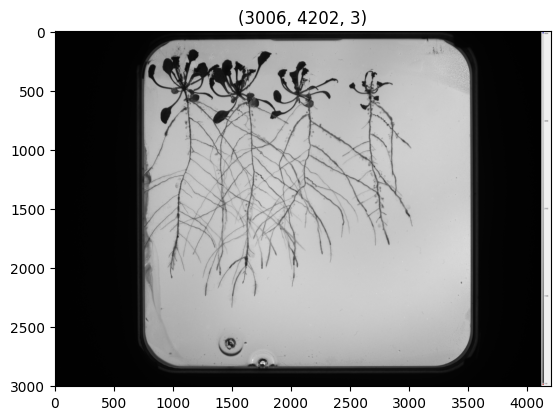

In [4]:
# storing paths in list
ims = [img_23_path[0], img_24_path[0], img_25_path[0], img_25_path[1]]

# Loading images
img23  = cv2.imread(ims[0])
img24  = cv2.imread(ims[1])
img25a = cv2.imread(ims[2])
img25b = cv2.imread(ims[3])

# Checking an image
print(img23.shape)
print(img23.dtype)

# h x w
height, widh = img23.shape[:2]
print(f"Width: {widh}, Height: {height}")

# center of image
center = (widh // 2, height // 2)
print(f"Center: {center}")

# Display
plt.title(str(img23.shape))
plt.imshow(img23, cmap='gray')
plt.show()

# Calling function to extract Petri dish

In [5]:
crop23, _   = extract_dish(img23)
crop24, _   = extract_dish(img24)
crop25a, _ = extract_dish(img25a)
crop25b, _ = extract_dish(img25b)

# storing original and cropped images in lists
imgs = [img23, img24, img25a, img25b]
crops = [crop23, crop24, crop25a, crop25b]

Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 91.0
Otsu algorithm selected the following threshold: 92.0
Otsu algorithm selected the following threshold: 94.0


# Display

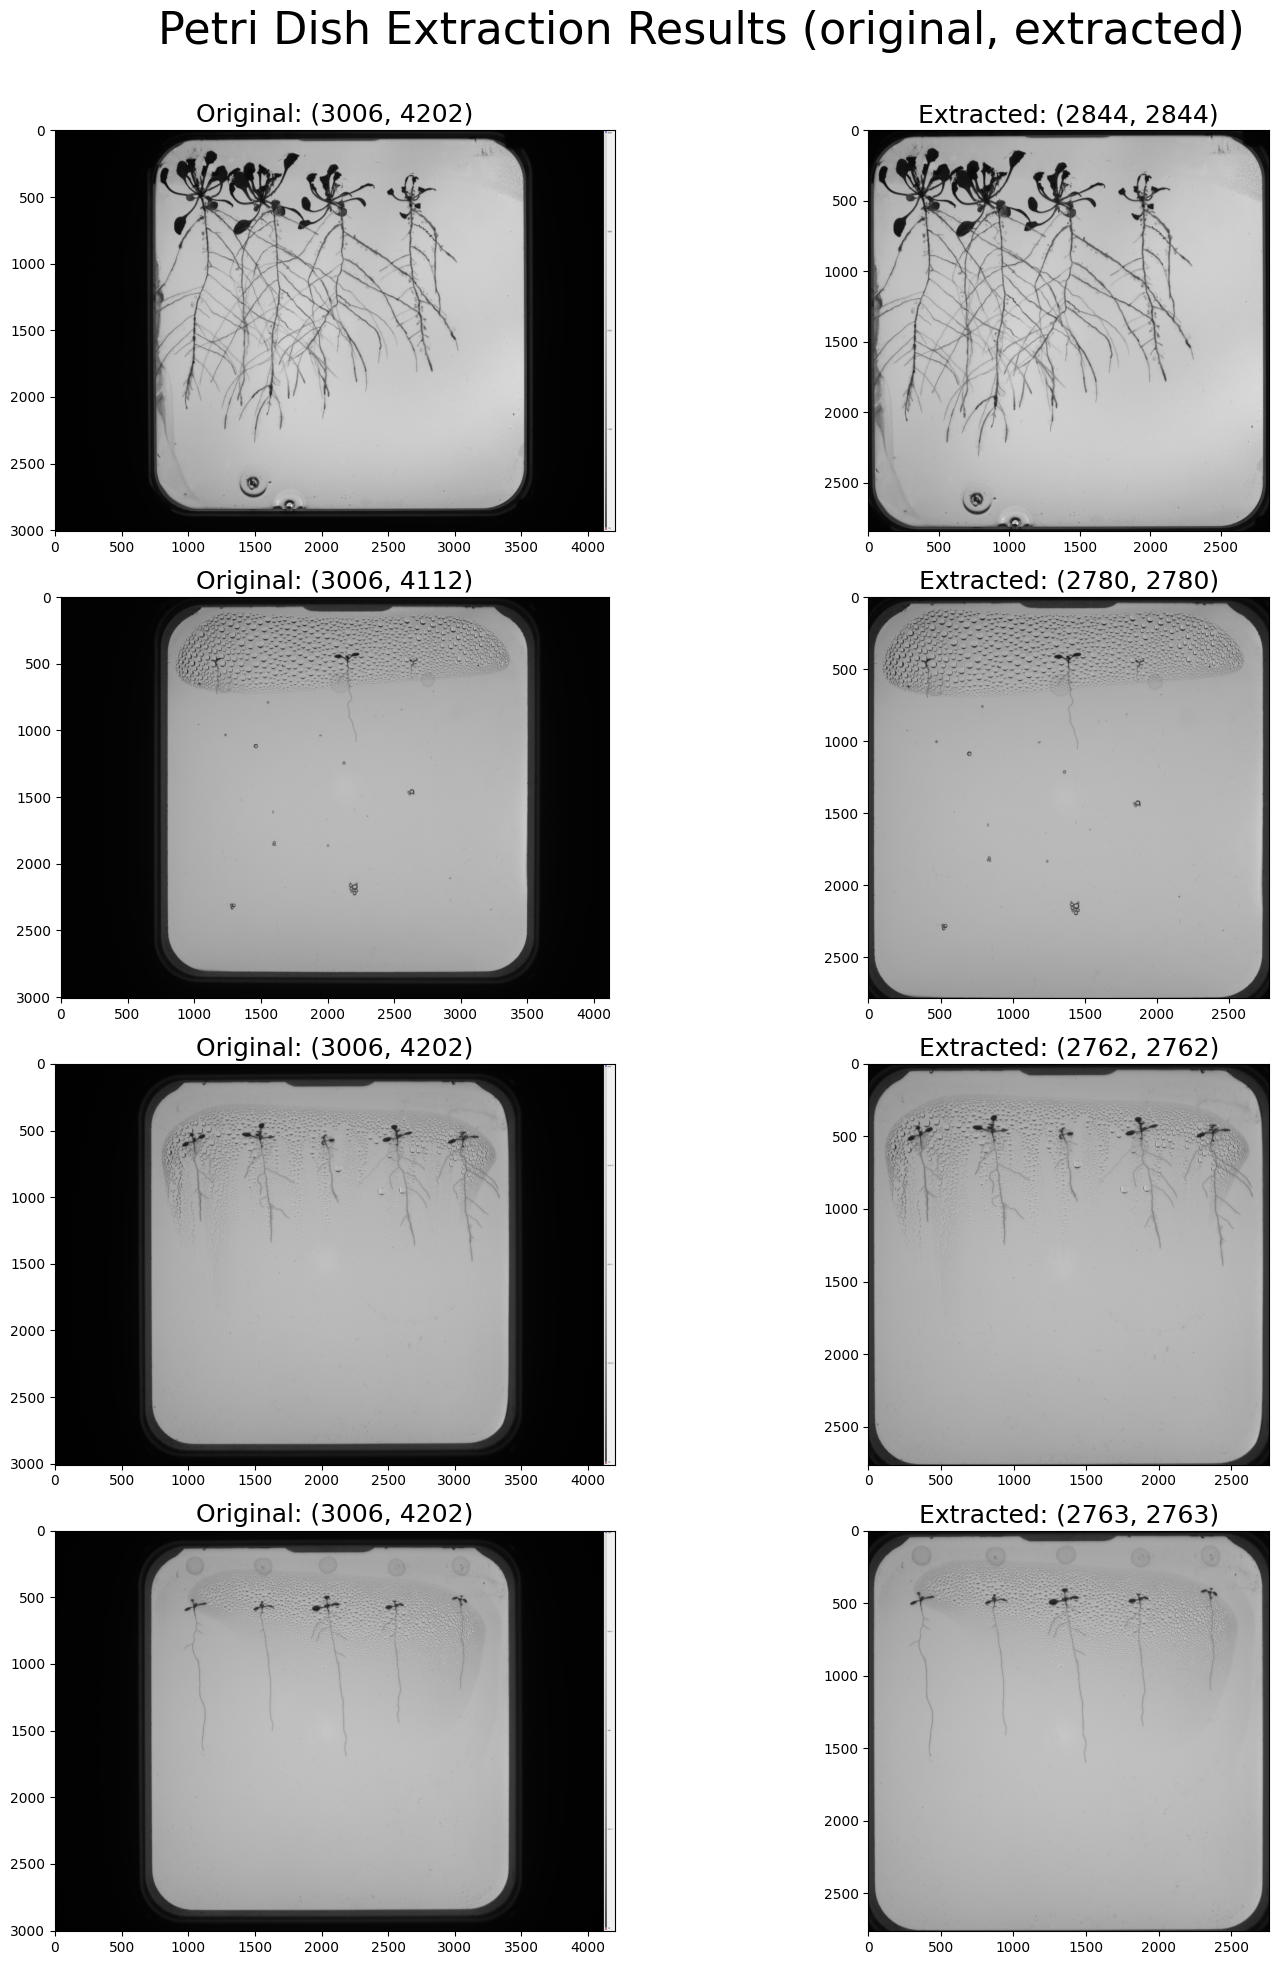

In [6]:
display_images(imgs, crops)